In [1]:
!pip install numpy torch sympy mod blobfile pandas seaborn matplotlib tqdm einops wand

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from contextlib import suppress
from dataclasses import dataclass, asdict
from datetime import datetime
from typing import Callable, Literal, Optional, Union, Tuple, List
from copy import deepcopy

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch import optim
import wandb
from tqdm.notebook import tqdm
import ipywidgets as widgets
import wandb
from torchvision.datasets import CIFAR10, MNIST, VisionDataset
from torchvision import transforms

import matplotlib as mpl
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.pyplot as plt

from patterns.dataset import ModularArithmetic, Operator
from patterns.transformer import Transformer
from patterns.utils import generate_run_name
from patterns.learner import Config, Reduction
from patterns.vision import VisionLearner, VisionConfig

from unifying.sweep import get_history, handle_outliers, extract_run, extract_slice, get_pivot, extract_slice_from_pivot, extract_run_from_pivot, exp_filter, METRICS
from unifying.plotting import plot, plot_slice, BLUE, RED, BLUES, REDS, plot_all_details, plot_details, create_heatmap
from matplotlib import cm, colors, gridspec


DEFAULT_MODULUS = 113
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sns.set_theme(style="darkgrid")

# Interpolations

## Plots


In [2]:

def plot_interpolation_overview(
    df: pd.DataFrame,
    unique_col: str = "weight_decay",
    smooth: Union[bool, float] = False,
    cmap="inferno",
    log_loss=True,
    log_x: bool = True,
    log_y: bool = True,
    title: str = "",
    metric: str = "test/acc",
    metric_label: str = "Accuracy",
    run_vals: List[float] = [0.0],
    plot_extra: bool = False,
    latex: str = "",
    suptitle: str = "",
):
    metric_label_short = (
        metric_label.split(" ")[1] if " " in metric_label else metric_label
    )

    num_snapshots = len(run_vals)

    # create a figure with a 2x2 grid of subplots
    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(num_snapshots, 2, width_ratios=[3, 2], hspace=0.25)

    pivot_table = get_pivot(
        df, unique_col, reindex=True, interpolate=True, columns=[metric]
    )
    unique_vals = sorted(df[unique_col].unique())

    ax1 = plt.subplot(gs[:, 0])
    y = pivot_table[metric].index
    mesh = create_heatmap(
        x=unique_vals,
        y=y,
        z=pivot_table[metric].values,
        ax=ax1,
        smooth=smooth,
        cmap=cmap,
        log_x=log_x,
        log_y=log_y,
        log_z=log_loss and "loss" in metric,
        title=title,
    )

    fig.colorbar(mesh, ax=ax1, label=metric_label)

    # Plot horizontal lines at the run_vals entries
    run_vals_lines = [(v + 0.0125 if v == 0 else v) for v in run_vals]
    ax1.vlines(run_vals_lines, y.min(), y.max(), color=RED)

    # Find the _step for each run where the train/acc first reaches 1.0
    interpolation = []
    convergence = []

    for i, val in enumerate(unique_vals):
        run = df.loc[(df[unique_col] == val), :]

        interp_max = run["train/acc"].max()
        interp_threshold = interp_max * 0.95
        interp_step = run.loc[run["train/acc"] > interp_threshold, "_step"].min()  # type: ignore
        interp_val = run.loc[run._step == interp_step, "train/acc"].values[0]  # type: ignore
        interpolation.append((interp_step, interp_val))

        conv_max = run[metric].max()
        conv_threshold = conv_max * 0.95
        conv_step = run.loc[run[metric] > conv_threshold, "_step"].min()  # type: ignore
        conv_val = run.loc[run._step == conv_step, metric].values[0]  # type: ignore
        convergence.append((conv_step, conv_val))

    ax1.plot(
        unique_vals,
        [v for (v, _) in interpolation],
        color="grey",
        linestyle="--",
        label="Interpolation",
    )
    ax1.plot(
        unique_vals,
        [v for (v, _) in convergence],
        color="grey",
        linestyle="--",
        label="Convergence",
    )

    for i, val in enumerate(run_vals):
        run = df.loc[(df[unique_col] == val), :]
        ax = plt.subplot(gs[i, 1])

        # Interpolation threshold
        unique_val_idx = unique_vals.index(val)

        interp_step, interp_val = interpolation[unique_val_idx]
        ax.vlines(interp_step, 0, interp_val, color="grey", linestyle="--", label=None)

        # Test convergence threshold
        conv_step, conv_val = convergence[unique_val_idx]
        ax.vlines(conv_step, 0, conv_val, color="grey", linestyle="--", label=None)

        ax.plot(run._step, run["train/acc"], color=BLUE, label="Train")
        ax.plot(run._step, run[metric], color=RED, label="Test")

        val_rounded = round(val, 2)
        
        ax.set_ylim([0.0, 1.05])
        ax.set_xscale("log")
        ax.set_xlim([1e0, df._step.max()])

        if i < len(run_vals) - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel("Step")

        ax_title = f"{metric_label_short} for ${latex}={val_rounded}$"
        ax.legend(title=ax_title, loc="lower right", title_fontsize=16, fontsize=14)

    plt.suptitle(suptitle)


In [58]:
INTERP_SWEEPS = ["kodd01ka", "wecya83q", "wqnakkjd", "awxzpem1"]
interp_sweep = get_history(*INTERP_SWEEPS, project="mnist-grokking", allow_duplicates=True)
interp_sweep_backup = interp_sweep.copy()



In [60]:
lr_factors = interp_sweep.lr_factor.unique()

intep_sweep = interp_sweep_backup.copy()
interp_sweep_backup = interp_sweep.copy()

interp_sweep["test/acc"]

1      0.125749
0      0.143713
1      0.059880
1      0.131737
0      0.095808
         ...   
204    0.520958
180    0.395210
339    0.520958
23     0.329341
105    0.341317
Name: test/acc, Length: 27000, dtype: float64

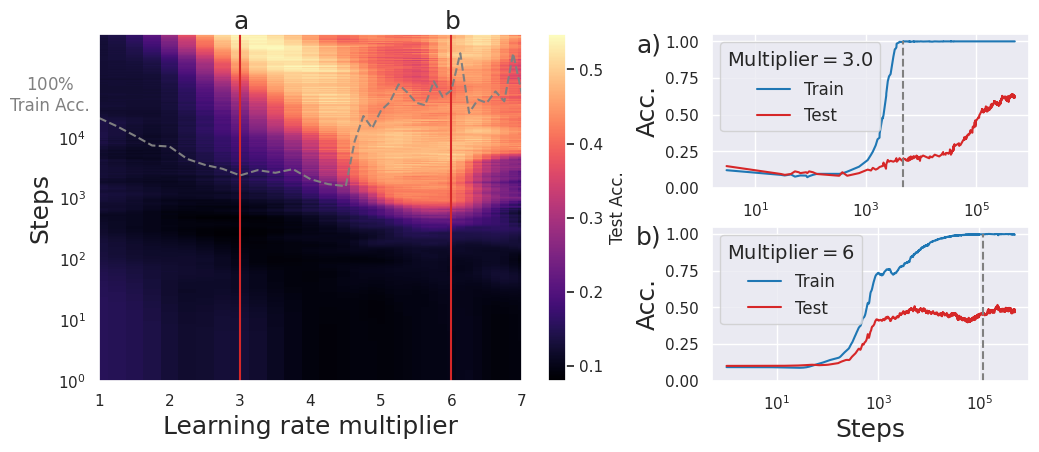

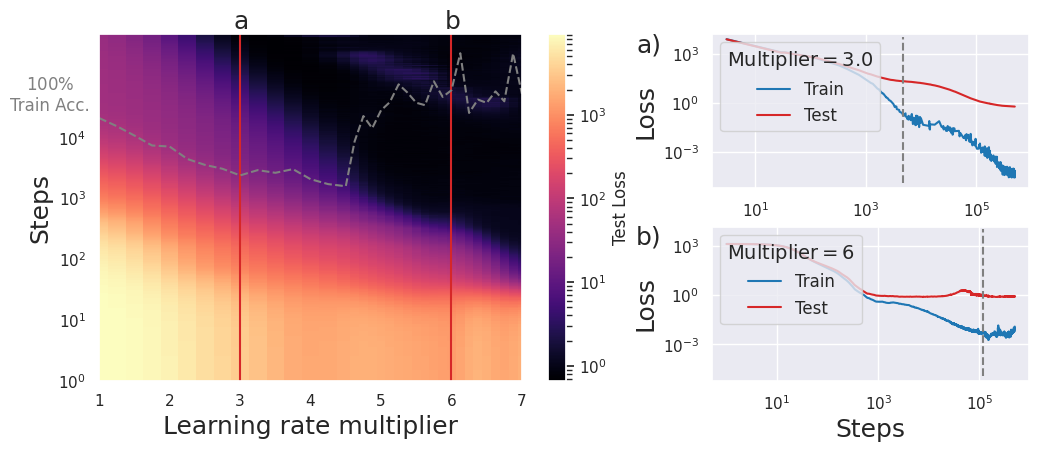

In [69]:
from scipy.ndimage import gaussian_filter, gaussian_filter1d


def plot_interpolation(
    df: pd.DataFrame,
    unique_col: str = "weight_decay",
    smooth: Union[bool, float] = False,
    cmap="inferno",
    log_loss=True,
    log_x: bool = True,
    log_y: bool = True,
    title: str = "",
    metric: str = "test/acc",
    metric_label: str = "Accuracy",
    run_vals: List[float] = [0.0],
    plot_extra: bool = False,
    latex: str = "",
    suptitle: str = "",
    figsize: Tuple[float, float] = (12, 6),
):
    metrics = METRICS[:-2]
    train_metric = metric.replace("test", "train")
    metric_label_short = (
        metric_label.split(" ")[1] if " " in metric_label else metric_label
    )

    num_snapshots = len(run_vals)

    # create a figure with a 2x2 grid of subplots
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(num_snapshots, 2, width_ratios=[5, 3], hspace=0.25)

    pivot_table = get_pivot(
        df, unique_col, reindex=True, interpolate=True, columns=metrics
    )
    unique_vals = sorted(df[unique_col].unique())

    ax1 = plt.subplot(gs[:, 0])
    y = pivot_table.loc[pivot_table.index < 500_000][metric].index
    
    if smooth:
        for m in metrics:
            _pivot_table = gaussian_filter(pivot_table[m], sigma=smooth)

            for i, unique_val in enumerate(unique_vals):
                pivot_table[(m, unique_val)] = _pivot_table[:, i]

    mesh = create_heatmap(
        x=unique_vals,
        y=y,
        z=pivot_table.loc[pivot_table.index<500_000][metric].values,
        ax=ax1,
        smooth=False,
        cmap=cmap,
        log_x=log_x,
        log_y=log_y,
        log_z=log_loss and ("loss" in metric),
        title=title,
    )
        
    ax1.set_ylabel("Steps", fontsize=18)
    ax1.set_xlabel(title, fontsize=18)
    fig.colorbar(mesh, ax=ax1, label=metric_label)

    # Plot horizontal lines at the run_vals entries
    run_vals_lines = [(v + 0.0125 if v == 0 else v) for v in run_vals]
    ax1.vlines(run_vals_lines, y.min(), y.max(), color=RED)

    # Find the _step for each run where the train/acc first reaches 1.0
    interpolation = []
    convergence = []

    interp_percent = 1.0

    for i, val in enumerate(unique_vals):
        run = df.loc[(df[unique_col] == val), :]

        interp_max = run["train/acc"].max()
        interp_threshold = interp_max * interp_percent
        interp_step = run.loc[run["train/acc"] >= interp_threshold, "_step"].min()  # type: ignore
        interp_val = run.loc[run._step == interp_step, "train/acc"].values[0]  # type: ignore
        interpolation.append((interp_step, interp_val))

        conv_max = run[metric].max()
        conv_threshold = conv_max * 0.95
        conv_step = run.loc[run[metric] > conv_threshold, "_step"].min()  # type: ignore
        conv_val = run.loc[run._step == conv_step, metric].values[0]  # type: ignore
        convergence.append((conv_step, conv_val))

    interpolation_smooth = gaussian_filter1d(np.array(interpolation), sigma=3.)

    ax1.plot(
        unique_vals,
        [v for (v, _) in interpolation_smooth],
        color="grey",
        linestyle="--",
        label="Interpolation",
    )
    # ax1.plot(
    #     unique_vals,
    #     [v for (v, _) in convergence],
    #     color="grey",
    #     linestyle="--",
    #     label="Convergence",
    # )
    ax1.text(
        0.3,
        50000,
        "$100\\%$\nTrain Acc.",
        fontsize=12,
        horizontalalignment="center",
        verticalalignment="center",
        color="grey",
    )

    for i, val in enumerate(run_vals):
        run = extract_run_from_pivot(pivot_table, val, smooth=False, metrics=metrics) # df.loc[(df[unique_col] == val), :]

        if i == 0:
            run = df.loc[(df[unique_col] == val), :]
        else:
            run = run.loc[run._step < 500_000]

        ax = plt.subplot(gs[i, 1])

        # Interpolation threshold
        unique_val_idx = unique_vals.index(val)


        # Test convergence threshold
        # conv_step, conv_val = convergence[unique_val_idx]
        # ax.vlines(conv_step, 0, conv_val, color="grey", linestyle="--", label=None)

        ax.plot(run._step, run[train_metric], color=BLUE, label="Train")
        ax.plot(run._step, run[metric], color=RED, label="Test")

        val_rounded = round(val, 2)

        interp_step, interp_val = interpolation[unique_val_idx]

        if "Acc" in metric_label:
            min_interp_val = 0
            ax.set_ylim(0.0, 1.05)
        else:
            min_loss, max_loss = min(df[metric].min(), df[train_metric].min()), max(df[metric].max(), df[train_metric].max())
            
            if log_loss:
                ax.set_ylim(min_loss * .5, max_loss + 0.5 * max_loss)
                ax.set_yscale("log")
            else:
                ax.set_ylim(-0.05, max_loss + 0.5 * max_loss)

            min_interp_val = min_loss
            interp_step, _ = interpolation[unique_val_idx]
            interp_val = max_loss

        ax.vlines(interp_step, min_interp_val, interp_val, color="grey", linestyle="--", label=None)

        # Plot "a" or "b" above the line on ax1
        line_label = "b" if i == 1 else "a"
        ax1.text(
            val + 0.0125,
            800000,
            line_label,
            fontsize=18,
            horizontalalignment="center",
            verticalalignment="center",
        )

        # Plot "a" or "b" at top-left of ax
        ax.text(
            -0.2,
            .93,
            line_label + ")",
            fontsize=18,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
        )

        ax.set_xscale("log")
        # ax.set_xlim([1e0, df._step.max()])
        ax.set_ylabel(metric_label_short, fontsize=18)


        ax.set_xticks([10, 1000, 100000])
        if i >= len(run_vals) - 1:
            ax.set_xlabel("Steps", fontsize=18)

        ax_title = f"${latex}={val_rounded}$"
        ax.legend(title=ax_title, loc="upper left", fontsize=12, title_fontsize=14)

    plt.suptitle(suptitle)

    slug = title.lower().replace(" ", "-") + "-" + metric.lower().replace("/", "-")
    plt.savefig(f"../figures/interpolation-{slug}.png", bbox_inches="tight")

def plot(**kwargs):
    plot_interpolation(
        interp_sweep,
        unique_col="lr_factor",  
        title="Learning rate multiplier",
        cmap="magma",
        latex=r"\mathrm{Multiplier}",
        log_x=False,
        suptitle="",
        metric_label="Test Acc.",
        **kwargs
    )   
    plt.show()

    plot_interpolation(
        interp_sweep,
        unique_col="lr_factor",  
        title="Learning rate multiplier",
        cmap="magma",
        latex=r"\mathrm{Multiplier}",
        log_x=False,
        suptitle="",
        metric="test/loss",
        metric_label="Test Loss",
        **kwargs
    )   
    plt.show()


plot(
    figsize=(12, 4.5),
    smooth=(10., 1.5),
    run_vals=[3., 6]
)

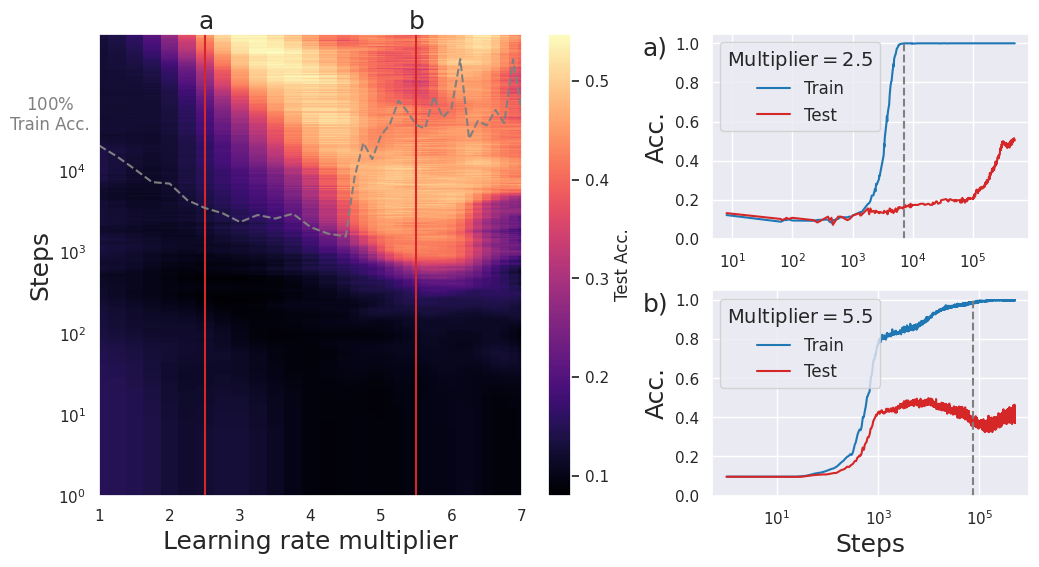

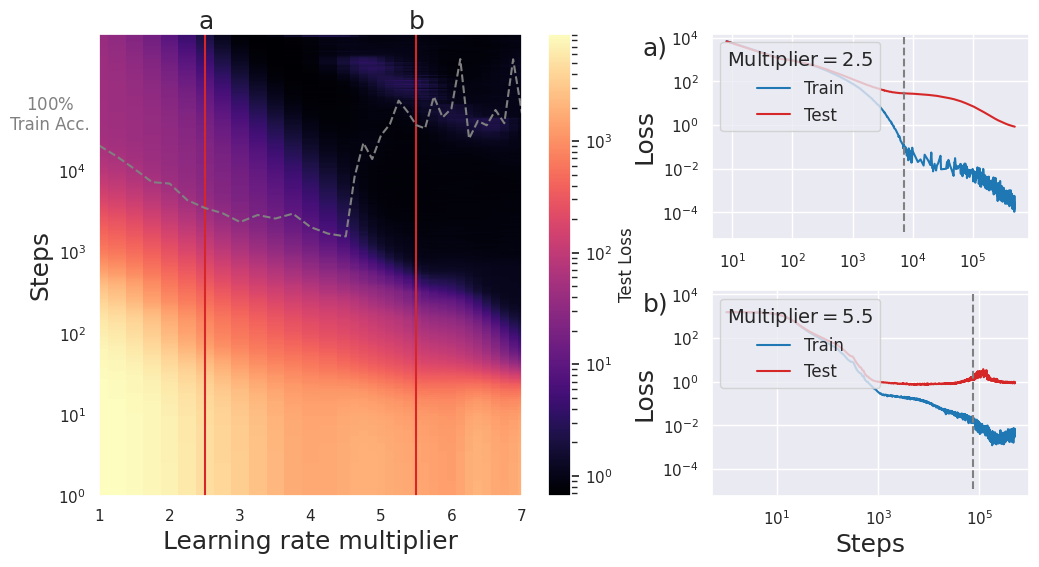

In [65]:
plot(smooth=(10., 1.5), run_vals=[2.5, 5.5])

In [5]:
ln_sweep = get_history("xwna3rhg", allow_duplicates=True)

# ln_sweep_cleaned = handle_outliers(
#     ln_sweep,
#     loss_cols=["train/loss"], 
#     action="keep",
#     unique_cols=["frac_train"],
#     threshold=0.0001,
#     late_epochs_ratio=0.6,
# )


def correct_label_noise(df: pd.DataFrame):
    # Correct the sweeps by dividing test/acc by 1-label_noise
    df = df.copy()

    lbl_noises = df.frac_label_noise.unique()

    for lbl_noise in lbl_noises:
        for metric in ["test/acc"]:
            df.loc[df.frac_label_noise==lbl_noise, metric] /= 1 - lbl_noise

    return df

ln_sweep_cleaned = correct_label_noise(ln_sweep)

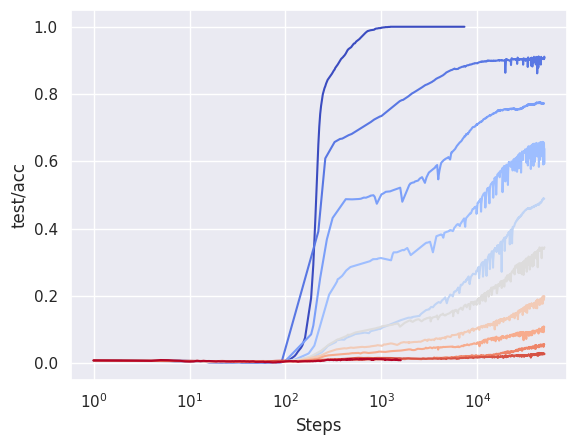

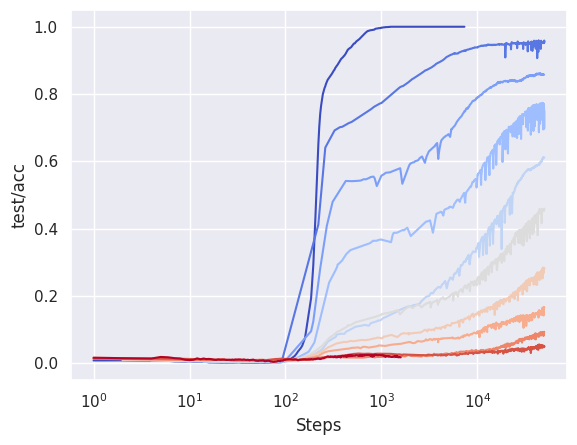

In [7]:
sns.lineplot(ln_sweep, x="_step", y="test/acc", hue="frac_label_noise", legend=False, palette="coolwarm", )
plt.xscale('log')
plt.xlabel("Steps")
plt.show()

sns.lineplot(ln_sweep_cleaned, x="_step", y="test/acc", hue="frac_label_noise", legend=False, palette="coolwarm", )
plt.xscale('log')
plt.xlabel("Steps")
plt.show()

In [4]:
plot_interpolation_overview(
    ln_sweep_cleaned,
    unique_col="frac_label_noise",  
    title="Fraction training noise",
    cmap="coolwarm",
    run_vals=[0.0, 0.05, 0.15],
    latex=r"f_\mathrm{noise}",
    log_x=False,
    suptitle="Modular Arithmetic"
)   

NameError: name 'gridspec' is not defined

<Figure size 1000x600 with 0 Axes>

In [2]:
frac_train_sweep = get_history("cnr2n43n", "759uhy5f", allow_duplicates=True, project="mnist-grokking")

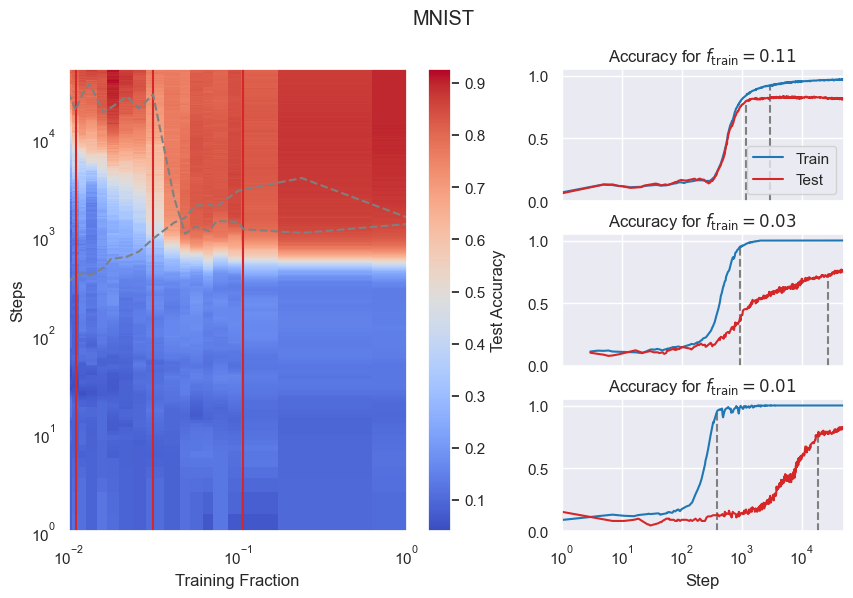

In [15]:
ft_vals = sorted(frac_train_sweep.frac_train.unique())
ft_selection = [ft_vals[-3], ft_vals[8], ft_vals[1]]

plot_interpolation_overview(
    frac_train_sweep,
    unique_col="frac_train",
    title="Training Fraction",
    cmap="coolwarm",
    run_vals=ft_selection,
    latex=r"f_\mathrm{train}",
    log_x=True,
    suptitle="MNIST"
) 

In [5]:
api = wandb.Api()
mnist_dd = api.run("jqhoogland/mnist-grokking/hbw3nlnb")
mnist_grok = api.run("jqhoogland/mnist-grokking/9i790lal")

mnist_dd_df = pd.DataFrame(mnist_dd.history())
mnist_grok_df = pd.DataFrame(mnist_grok.history())

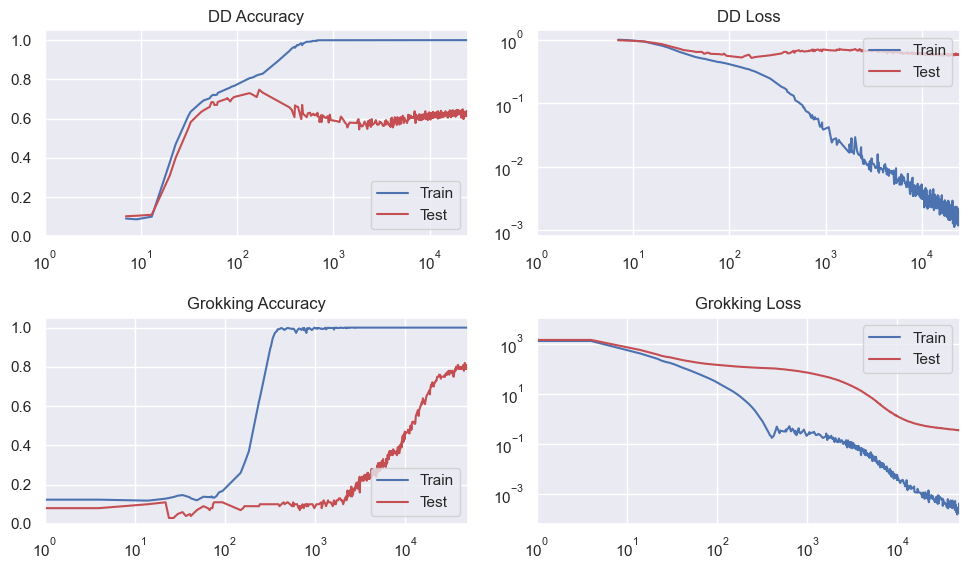

In [14]:
# 2 by 2 grid of subplots
# Acc on left, loss on right
# DD on top, Grokking on bottom
# Train in blue, test in red

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for i, (df, title) in enumerate(zip([mnist_dd_df, mnist_grok_df], ["DD", "Grokking"])):
    ax = axes[i, 0]
    # Sort by steps
    df = df.sort_values("_step")

    ax.plot(df._step, df["train/acc"], color=BLUE, label="Train")
    ax.plot(df._step, df["test/acc"], color=RED, label="Test")
    ax.set_title(f"{title} Accuracy")
    ax.set_ylim([0., 1.05])
    ax.set_xscale("log")
    ax.set_xlim([1e0, df._step.max()])
    ax.legend(loc="lower right")

    ax = axes[i, 1]
    ax.plot(df._step, df["train/loss"], color=BLUE, label="Train")
    ax.plot(df._step, df["test/loss"], color=RED, label="Test")
    ax.set_title(f"{title} Loss")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([1e0, df._step.max()])
    ax.legend(loc="upper right")

# More space between rows
fig.tight_layout(pad=1.5)


# Can we devise an architecture that displays both grokking & epoch-wise dd?

For grokking to occur, we must:
- Shrink the size of the dataset.
- Increase the scale of initialization.

For EWDD to occur, we must:
- Shrink the size of the dataset.
- Apply label noise.

Both involve a timescale separation in learning dynamics, so we should probably avoid models that use a residual stream (which prevent vanishing/exploding gradients).

(This might explain part of why DD has been hard to demonstrate in transformers?)

Grokking on MNIST has required FCNs. My guess is that this is because convnets have too strong a prior towards the formation of good representations. 

In [44]:
class CNN(nn.Module):
    """4 Conv layers + 1 FCN"""
    
    def __init__(self, in_size=784, growth_rate=8, num_layers=3, num_classes=10, in_channels=1):
        self.growth_rate = growth_rate
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.in_size = in_size

        super().__init__()

        conv_layers = []

        width = int(np.sqrt(in_size))

        def add_layer(n_channels_before, n_channels_after):
            conv_layers.append(nn.Conv2d(n_channels_before, n_channels_after, 3, padding=1, stride=1, bias=True))
            conv_layers.append(nn.BatchNorm2d(n_channels_after))
            conv_layers.append(nn.ReLU())
            conv_layers.append(nn.MaxPool2d(2))

        add_layer(in_channels, growth_rate)

        for i in range(num_layers - 1):
            n_channels_before, n_channels_after = growth_rate * (2 ** i), growth_rate * (2 ** (i+1))
            add_layer(n_channels_before, n_channels_after)
            width = int((width - 3 + 2 * 1) / 1 + 1)
            width = int((width - 2) / 2 + 1)
            
        self.encoder = nn.Sequential(*conv_layers)
    
        hidden_size = 2048 # width * width * growth_rate * (2 ** (num_layers - 1))

        self.decoder = nn.Sequential(
            # nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

@dataclass
class CNNConfig(VisionConfig):
    # Model
    in_size: int = 784
    num_layers: int = 3
    num_classes: int = 10
    growth_rate: int = 8
    in_channels: int = 1


class CNNLearner(VisionLearner):
    Config = CNNConfig
    Dataset = Union[VisionDataset, Subset[VisionDataset]]

    @classmethod
    def get_model(cls, config: Config) -> nn.Module:
        model = CNN(
            num_layers=config.num_layers,
            num_classes=config.num_classes,
            growth_rate=config.growth_rate,
            in_size=config.in_size,
            in_channels=config.in_channels,
        )

        if config.load_path is not None:
            model.load_state_dict(torch.load(config.load_path))

        model.to(config.device)

        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Model has {num_params} trainable parameters")

        return model

    @staticmethod
    def criterion(outputs, targets, reduction: Reduction = "mean"):
        """
        Wrapper around MSE
        """
        logits = outputs
        one_hot_targets = F.one_hot(targets, num_classes=10).float()
        return F.mse_loss(logits, one_hot_targets, reduction=reduction)

    
cifar_config = CNNConfig(
    num_layers=3,
    growth_rate=32,
    init_scale=1.,
    # momentum=(0.8, 0.9),
    in_size=32 * 32,
    in_channels = 3,
    #
    wandb_project="cifar-grokking",
    frac_train=1/60.,
    frac_label_noise=0.2,
    batch_size=256,
    num_training_steps=int(1e6),
    init_mode="uniform",
    lr=1e-4, # 1e-3
    weight_decay=1e-3, # 1e-2
    seed=0,
    device=DEVICE,
    use_sgd=False
    # criterion="mse"
)

mnist_train = MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

mnist_test = MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

cifar_train = CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

cifar_test = CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

# mnist_learner = CNNLearner.create(
#     mnist_config,
#     mnist_train,
#     mnist_test,
# )

cifar_learner = CNNLearner.create(
    cifar_config,
    cifar_train,
    cifar_test,
)

Files already downloaded and verified
Files already downloaded and verified
Model has 114186 trainable parameters


In [45]:
try:
    wandb.init(
        project="cifar-grokking",
        settings=wandb.Settings(start_method="thread"),
        config=asdict(cifar_config),  # Default config
    )
    cifar_learner.train()
except KeyboardInterrupt:
    wandb.finish()

  0%|          | 0/250000 [00:00<?, ?it/s]

In [3]:
mnist_dd_config = CNNConf(
    wandb_project="mnist-dd",
    frac_train=1.,
    frac_label_noise=0.2,
    batch_size=256,
    num_training_steps=int(60e3/256 * 1000),
    num_layers=2,
    width=200,
    init_mode="uniform",
    init_scale=1.,
    lr=1e-3, # 1e-3
    weight_decay=1e-2, # 1e-2
    seed=0,
    device=DEVICE,
    use_sgd=False
    # criterion="mse"
)


mnist_dd_learner = CNNLearner.create(
    mnist_dd_config,
    mnist_train,
    mnist_test,
)

NameError: name 'MNISTConfig' is not defined

In [ ]:
try:
    wandb.init(
        project=mnist_dd_config.wandb_project,
        settings=wandb.Settings(start_method="thread"),
        config=asdict(mnist_dd_config),  # Default config
    )
    mnist_dd_learner.train()
except KeyboardInterrupt:
    wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jqhoogland. Use `wandb login --relogin` to force relogin


  0%|          | 0/997 [00:00<?, ?it/s]

test/acc,▁▄▅▇▇▇▇▇▇▇▇▇▇█▇█▇███████████████████████
test/efficiency,█▆▅▄▄▄▃▄▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test/loss,█▆▅▄▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████████
train/efficiency,█▆▅▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▆▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
weight/cos_sim_with_init,███▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
weight/dist_from_init,▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
weight/norm,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇██
test/acc,0.7946
test/efficiency,0.02905


### Can we induce grokking in CIFAR-10?

In [ ]:
# Transform to black & white & crop to 28 x 28 & normalize

cifar_train_bw = CIFAR10(root="../data", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,), (0.2023,)),
    transforms.Grayscale(),
    transforms.CenterCrop(28),
]))
cifar_test_bw = CIFAR10(root="../data", train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,), (0.2023,)),
    transforms.Grayscale(),
    transforms.CenterCrop(28),
]))

# First try with the MNIST model

cifar_config_bw = MNISTConfig(
    wandb_project="cifar-grokking",
    frac_train=1/60.,
    frac_label_noise=0.0,
    batch_size=200,
    num_training_steps=int(1e6),
    num_layers=2,
    width=200,
    init_mode="uniform",
    init_scale=6.,
    lr=1e-3, # 1e-3
    weight_decay=1e-2, # 1e-2
    seed=0,
    device=DEVICE,
    use_sgd=False
    # criterion="mse"
)

cifar_learner_bw = MNISTLearner.create(
    cifar_config_bw,
    cifar_train_bw,
    cifar_test_bw,
)

def run(learner: BaseLearner, config: Config):
    try:
        wandb.init(
            project=config.wandb_project,
            settings=wandb.Settings(start_method="thread"),
            config=asdict(config),
        )
        learner.train()
    except KeyboardInterrupt:
        wandb.finish()

# run(cifar_config_bw, cifar_learner_bw)

Files already downloaded and verified
Files already downloaded and verified
Model has 199210 trainable parameters


In [ ]:
class ResBlock(ExtModule):
    def __init__(self, in_channels, out_channels, kernel_size=3, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1)
        
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        if self.conv3:
            x = self.conv3(x)
        
        out += x
        return F.relu(out)

class ResNet(ExtModule):
    def __init__(
        self, 
        num_blocks: int,
        num_classes: int,
        in_channels: int = 3,
        in_width: int = 32,
        init_scale: float = 1.,
    ):
        super().__init__()

        self.in_width = in_width
        self.in_channels = in_channels
        self.num_blocks = num_blocks
        self.num_classes = num_classes
        self.init_scale = init_scale
        
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=5, stride=2, padding=0, bias=False)
        size = (in_width - 5) // 2 + 1

        self.bn1 = nn.BatchNorm2d(32)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        size = (size - 3) // 2 + 1

        resblocks = [
            ResBlock(32 * (2 ** i), 32 * (2 ** (i + 1)), strides=2, kernel_size=3)
            for i in range(num_blocks)
        ]

        for i, _ in enumerate(resblocks):
            size = (size - 3) // 2 + 1

        self.resblocks = nn.Sequential(*resblocks)

        self.flatten = nn.Flatten()
        num_channels = 32 * (2 ** num_blocks)
        self.fc1 = nn.Linear(num_channels * size, num_classes)

        self.init_weights()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)

        out = self.maxpool(out)
        out = self.resblocks(out)
        out = self.flatten(out)
        out = self.fc1(out)
        return out
    

@dataclass
class CIFARConfig(VisionConfig):
    num_blocks: int = 2
    num_classes: int = 10
    in_channels: int = 3
    in_width: int = 32 


class CIFARLearner(BaseLearner):
    Config = CIFARConfig
    Dataset = Union[CIFAR10, Subset[CIFAR10]]

    @classmethod
    def create(
        cls,
        config: Config,
        trainset: Dataset,
        testset: Dataset,
    ) -> "BaseLearner":
        torch.manual_seed(config.seed)
        model = cls.get_model(config)
        optimizer = cls.get_optimizer(config, model)
        trainloader = cls.get_loader(config, trainset)
        testloader = cls.get_loader(config, testset, train=False)
        return cls(model, optimizer, config, trainloader, testloader)

    @staticmethod
    def get_loader(config: Config, dataset: Dataset, train=True) -> DataLoader[Dataset]:
        def add_label_noise(dataset: CIFARLearner.Dataset, frac_label_noise: float) -> CIFARLearner.Dataset:
            num_samples = len(dataset)
            num_errors = int(num_samples * frac_label_noise)
            
            origin_indices = torch.randperm(num_samples)[:num_errors]
            target_indices = origin_indices.roll(1)

            for origin, target in zip(origin_indices, target_indices):
                dataset.targets[origin] = dataset.targets[target]  # TODO: Make this not in-place

            return dataset

        if config.frac_label_noise > 0.0:
            dataset = add_label_noise(dataset, config.frac_label_noise)

        if train and config.frac_train < 1.0:
            dataset = Subset(
                dataset, 
                list(range(int(len(dataset) * config.frac_train)))
            )

        return DataLoader(
            dataset,
            batch_size=config.batch_size,
            shuffle=train,
        )

    @classmethod
    def get_model(cls, config: Config) -> nn.Module:
        model = ResNet(
            num_blocks=config.num_blocks,
            num_classes=config.num_classes,
            in_channels=config.in_channels,
            in_width=config.in_width,
            init_scale=config.init_scale,
        )

        if config.load_path is not None:
            model.load_state_dict(torch.load(config.load_path))

        model.to(config.device)

        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Model has {num_params} trainable parameters")

        return model

cifar_config = CIFARConfig(
    batch_size=256,
    wandb_project="cifar10-grokking",
    frac_train=0.0167,
    init_scale=8.,
    frac_label_noise=0.2,
    num_training_steps=int(60000. / 256 * 200),
)

cifar_train = CIFAR10(root="../data", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,), (0.2023,)),
]))
cifar_test = CIFAR10(root="../data", train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,), (0.2023,)),
]))

cifar_learner = CIFARLearner.create(
    cifar_config,
    trainset=cifar_train,
    testset=cifar_test,
)    

run(cifar_learner, cifar_config)

Files already downloaded and verified
Files already downloaded and verified
Model has 280106 trainable parameters


RuntimeError: The size of tensor a (4) must match the size of tensor b (7) at non-singleton dimension 3

### Can we interpolate just by varying initialization scale and label noise?

## Miscellaneous


### Can we induce epoch-/regularization-wise DD in shallow models?

### Can we induce epoch-wise DD in transformers?